In [1]:
import torch
from src.myChatGPT import *
from src.metrics import *
#from src.exp_weighted_pairs import *

import matplotlib.pyplot as plt
import numpy as np



 !$&',-.3:;?ABCDEFGHIJKLMNOPQRSTUVWXYZabcdefghijklmnopqrstuvwxyz


In [2]:
cl_cnt, cl_id = classes_count(vocab_size, training_set)
print(cl_cnt[0:36])        
print(cl_id[0:36])        

1003597
tensor([6279,    0,    0,    0,    0,  210,    0,    2,    0,   27,    0,    0,
           0, 3364, 1434, 1066,  721,  375, 1105,  718, 1382, 2225,  183,  496,
         881, 1278,  884, 1007,  691,  222,  471, 1504, 3713,  204,  151, 2438])
tensor([  35, 2318, 2796,  114, 3237, 3433, 3506, 3970,  383, 3776,  391,  126,
        4008, 2796,  114, 3237, 3433, 3506, 3970,  383, 3778,  520,    0,   18,
        1217, 3111, 3697, 3763, 3771,   80, 1022, 3113, 3817, 3119, 4203, 2847])


sorted  tensor([25004, 21586, 20588,  ...,     0,     0,     0]) 4225
sorted  tensor([10.1268,  9.9798,  9.9325,  ...,    -inf,    -inf,    -inf]) 4225


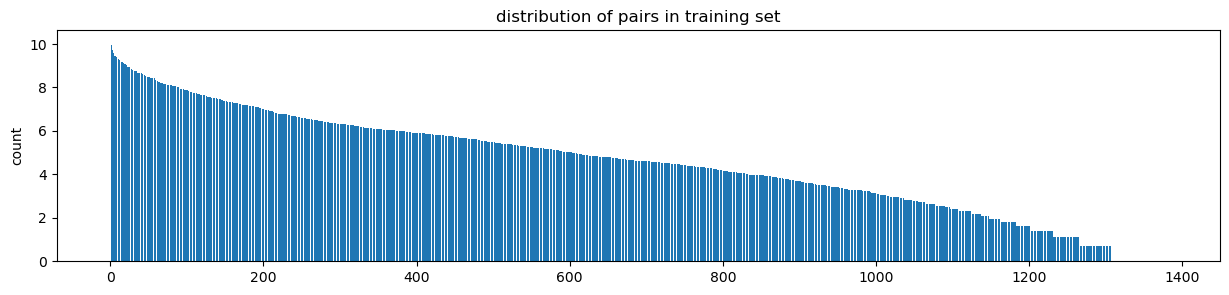

In [3]:
def plot_pairs(dist, title):
    #sorted = sorted[:10]
    print("sorted ", dist, len(dist))
    print("sorted ", torch.log(dist), len(dist))
    fig, ax = plt.subplots(figsize=(15,3))
    plt.bar(range(len(dist)), torch.log(dist))
    plt.title(title)
    #plt.xlabel('variable X (bin size = 5)')
    plt.ylabel('count')
    plt.show()

sorted, indices = torch.sort(cl_cnt, descending=True)
plot_pairs(sorted, 'distribution of pairs in training set')

In [4]:
weights = torch.zeros_like(cl_id, dtype=torch.float32)
for i in range(cl_id.shape[0]):
    weights[i] = 1.0/cl_cnt[cl_id[i]]

In [18]:
from torch.utils.data import WeightedRandomSampler
sampler = WeightedRandomSampler(weights, config.iterations*config.batch_size, replacement=True)
weighted_training_generator = torch.utils.data.DataLoader(training_set, sampler=sampler, batch_size = config.batch_size)  

10000
tensor([432,   0,   0,   0,   0, 458,   0, 444,   0, 466,   0,   0,   0, 500,
        496, 479, 436, 449, 447, 466, 480, 508, 468, 479, 440, 472, 413, 428,
        486, 440, 462, 469, 488, 474, 458, 470])
tensor([4107,  720, 3947, 2996, 1837, 1141, 1607, 1821, 2738, 1278, 1337,   17,
        2866, 3549, 2918, 3261, 3882, 3766, 1599, 3566, 3886, 3040,  470, 2848,
        3246,   86,   98, 2665, 2117, 3044,  892, 2720, 2415, 1583, 3496,  480])
sorted  tensor([536, 531, 531,  ...,   0,   0,   0]) 4225
sorted  tensor([6.2841, 6.2748, 6.2748,  ...,   -inf,   -inf,   -inf]) 4225


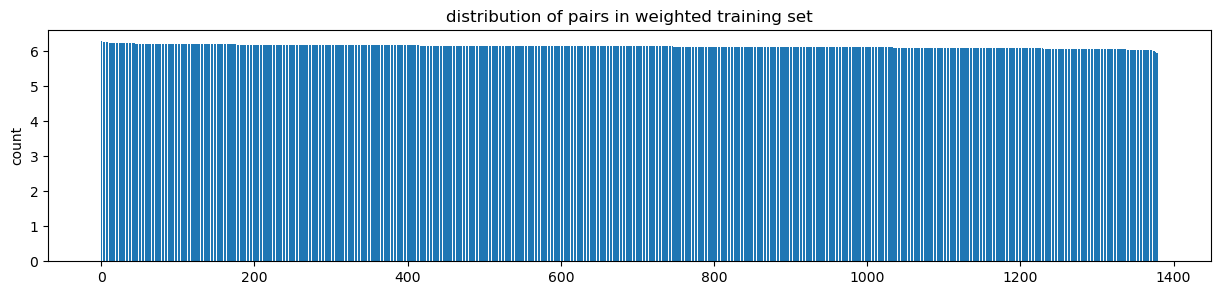

In [19]:
def classes_count2(vocab_size, training_set):
    cl_cnt = torch.zeros(vocab_size*vocab_size, dtype=torch.long)
    cl_id = torch.zeros(len(training_set), dtype=torch.long)
    print(len(training_set))
    for i, d in enumerate(training_set):
        xx,yy = d
        for batch in range(xx.shape[0]):
            
            x=xx[batch,-1]
            y=yy[batch,-1]
            c = x*vocab_size + y
            cl_cnt[c] += 1
            cl_id[i]=c
    return cl_cnt, cl_id

cl_cnt2, cl_id2 = classes_count2(vocab_size, weighted_training_generator)
print(cl_cnt2[0:36])        
print(cl_id2[0:36])   

sorted2, indices2 = torch.sort(cl_cnt2, descending=True)
plot_pairs(sorted2, "distribution of pairs in weighted training set")

 train_loss: 1.089100956916809
 val_loss: 1.3131660223007202
torch.Size([4225])
sorted  tensor([3225, 2123, 2050,  ...,    0,    0,    0]) 4225
sorted  tensor([8.0787, 7.6606, 7.6256,  ...,   -inf,   -inf,   -inf]) 4225


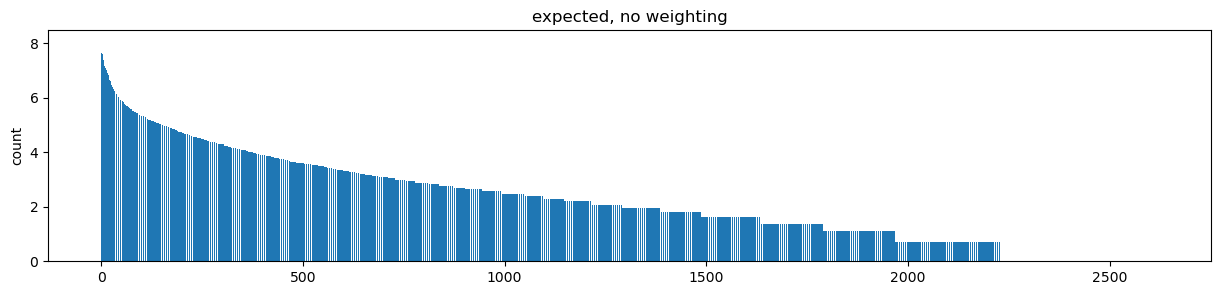

In [10]:
model = get_model()
optimizer = torch.optim.AdamW(model.parameters(), lr = config.learning_rate)

try:
    checkpoint = torch.load(config.model_path)
    print(f" train_loss: {checkpoint['train_loss']}")
    print(f" val_loss: {checkpoint['val_loss']}")

    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    #torch.set_rng_state(checkpoint['rng_state'])       
except:
    print("no checkpoint")
    pass

preds = expected_x_got_y(vocab_size, model, validation_generator)
sorted, _ = torch.sort(flatten(vocab_size, preds.long()), descending=True)
plot_pairs(sorted, "expected, no weighting")

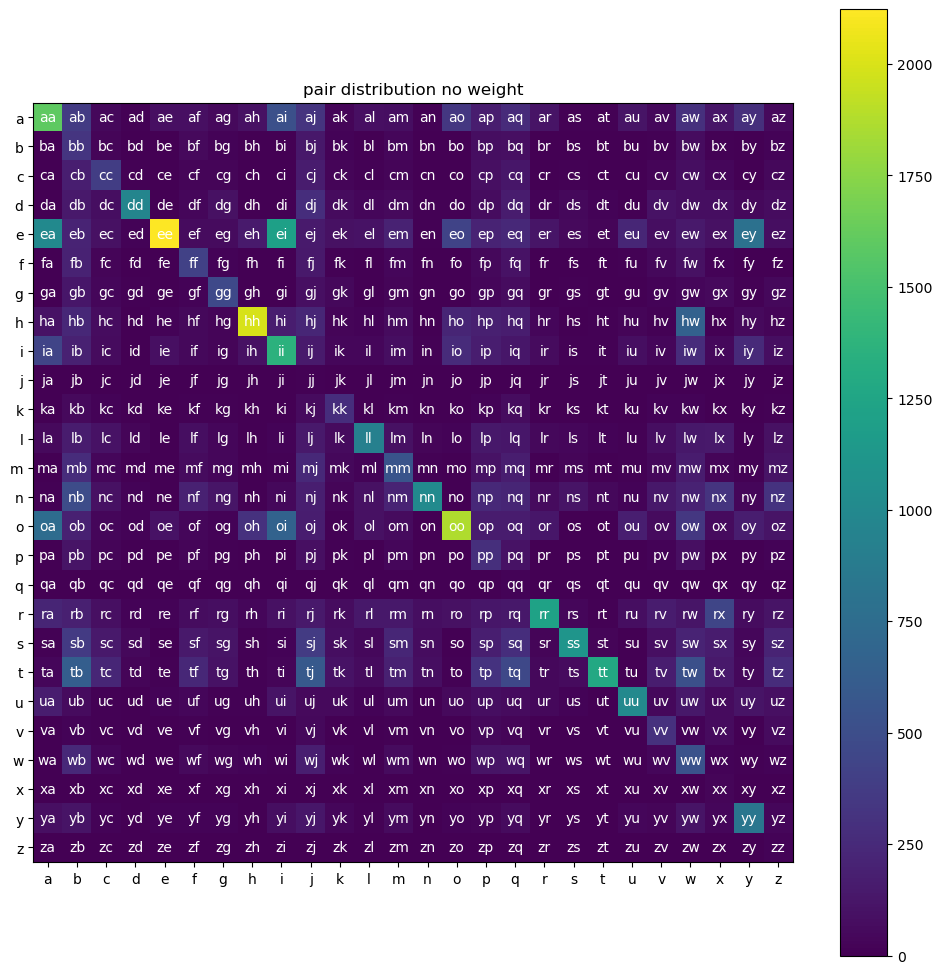

In [20]:
def plot(title, ini, fin, res):
    fig, ax = plt.subplots(figsize=(10,10))
    
    labels = decode(range(ini,fin))
    ax.set_xticks(np.arange(len(labels)), labels=labels)
    ax.set_yticks(np.arange(len(labels)), labels=labels)

    im = ax.imshow(res[ini:fin,ini:fin].cpu())
    fig.tight_layout()
    fig.colorbar(im)
    ax.set_title(title)
    #fig.tight_layout()    

    for i in range(len(labels)):
        for j in range(len(labels)):
            text = ax.text(j, i, labels[i]+labels[j],
                        ha="center", va="center", color="w")

    plt.show()



plot("pair distribution no weight", 39, 65, preds) 
#model.train()

In [22]:
model = get_model()
optimizer = torch.optim.AdamW(model.parameters(), lr = config.learning_rate)
config.use_wandb = True
config.name = "weighted training set"
train(model, optimizer, weighted_training_generator, config)

4.399699687957764 4.398036479949951
step 0: train loss: 4.012063980102539,  val_loss: 3.997154712677002
step 1: train loss: 2.5138602256774902,  val_loss: 2.5004446506500244
step 2: train loss: 2.4304332733154297,  val_loss: 2.436906099319458
step 3: train loss: 2.2987301349639893,  val_loss: 2.3128061294555664
step 4: train loss: 2.121603488922119,  val_loss: 2.141486406326294
step 5: train loss: 1.9952940940856934,  val_loss: 2.0316226482391357
step 6: train loss: 1.8915830850601196,  val_loss: 1.9562515020370483
step 7: train loss: 1.8061747550964355,  val_loss: 1.8837599754333496
step 8: train loss: 1.7364634275436401,  val_loss: 1.8130931854248047
step 9: train loss: 1.6823177337646484,  val_loss: 1.76760733127594
step 10: train loss: 1.6264387369155884,  val_loss: 1.7303844690322876
step 11: train loss: 1.5864930152893066,  val_loss: 1.6857352256774902
step 12: train loss: 1.5512036085128784,  val_loss: 1.6480320692062378
step 13: train loss: 1.5186495780944824,  val_loss: 1.6321

loss/train,█▄▄▄▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
loss/val,█▄▄▃▃▃▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
loss/train,1.04519
loss/val,1.3982


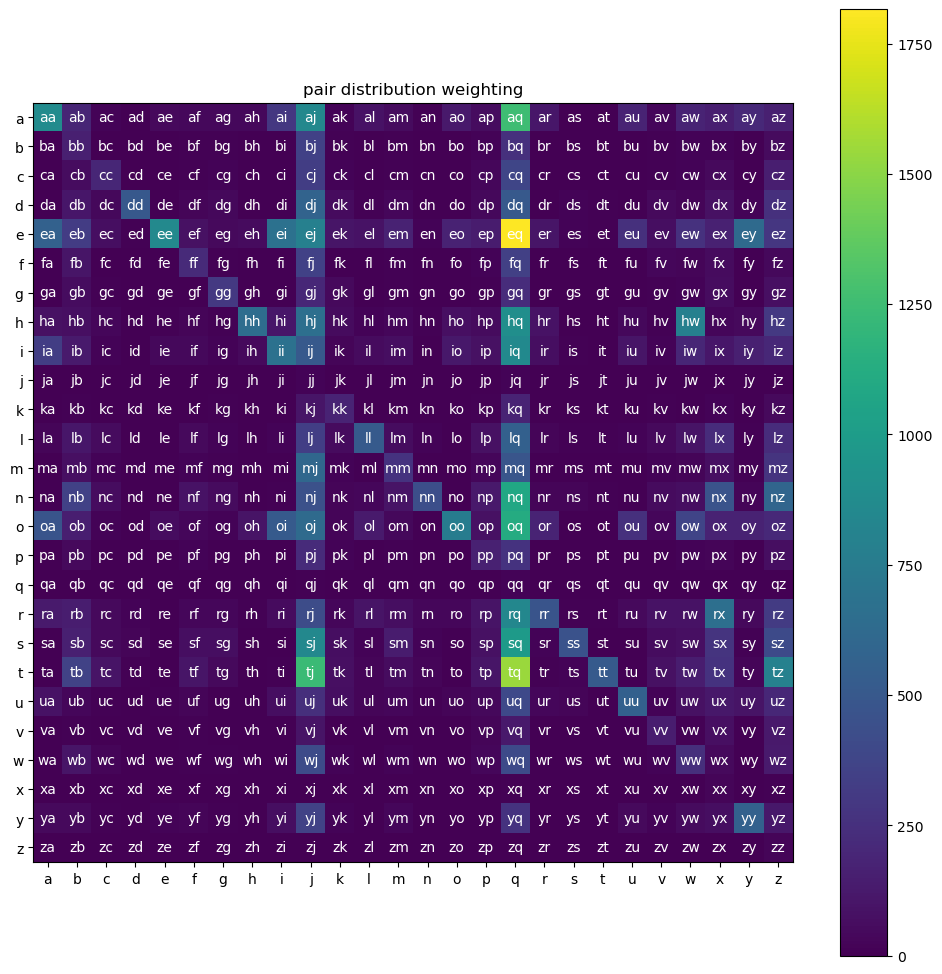

In [24]:
preds = expected_x_got_y(vocab_size, model, validation_generator)
plot("pair distribution weighting", 39, 65, preds) 

In [ ]:
def data_distributions():
    res = torch.zeros([vocab_size, vocab_size], dtype=torch.long, device = device)
    for i in range(len(tokens)-1):
        res[tokens[i], tokens[i+1]] +=1
    return res




In [ ]:
data_dist = data_distributions()
preds = expected_x_got_y()



In [ ]:
plot("'xy' expected x but got y", 39, 65, preds)    


In [ ]:
def flatten(dist):
    out = torch.zeros([dist.shape[0]*dist.shape[1]], dtype=torch.long)
    print(out.shape)
    for i in range(dist.shape[0]):
        for j in range(dist.shape[1]):
            out[j*vocab_size+i] += dist[i,j].cpu()
    return out


sorted, _ = torch.sort(cc, descending=True)
plot_pairs(sorted)

sorted, _ = torch.sort(flatten(data_dist), descending=True)
plot_pairs(sorted)


In [ ]:
sorted, _ = torch.sort(flatten(preds.long()), descending=True)
plot_pairs(sorted)
    

In [ ]:
print (res)

In [ ]:
checkpoint = torch.load(config.model_path)
model.load_state_dict(checkpoint['model_state_dict'])
print(f" train_loss: {checkpoint['train_loss']}")
print(f" val_loss: {checkpoint['val_loss']}")
#print(model.generate(1500))             
print(checkpoint["config"])

In [ ]:
preds = expected_x_got_y(vocab_size, model, validation_generator)
sorted, _ = torch.sort(flatten(preds.long()), descending=True)
plot_pairs(sorted)

In [ ]:
train(model, training_generator)